# Analysis of voter turnout of Municipalities of Switzerland

## Install and import libraries

In [22]:
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install nbconvert[webpdf]

In [23]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import copy

from sklearn.metrics import r2_score
from scipy.stats import linregress
from scipy.stats import norm 
from scipy import stats 

from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show
from bokeh.sampledata.periodic_table import elements
from bokeh.models import Slope
from bokeh.palettes import Inferno11

## Load data

In [24]:
municipalities = pd.read_csv("data/preprocessed/je-d-21.03.01-gemeindeportraits-preprocessed.csv",           sep=";")
turnouts2023   = pd.read_csv("data/preprocessed/sd-t-17.02-NRW2023-wahlbeteiligung-appendix.csv",            sep=";")
turnouts2019   = pd.read_csv("data/preprocessed/sd-t-17.02-NRW2019-wahlbeteiligung-gemeinden-APPENDIX.csv",  sep=";")

# Élections cantonales neuchâteloises de 2021: Evolution du taux de participation
# https://www.ne.ch/autorites/CHAN/CHAN/elections-votations/stat/Pages/210418.aspx
turnoutsNE     = pd.read_csv("data/preprocessed/ne-2021-04-18-cantonal-elections.csv",                     sep=";")

## Rename column names

In [25]:
turnouts2023 = turnouts2023[ ["geoLevelName", "wahlbeteiligung"] ]
turnouts2023.rename(columns = {
    'wahlbeteiligung': 'turnout2023', 
    'geoLevelName':    'Municipality'
},  inplace = True)

In [26]:
turnouts2019.rename(columns = {
    'wahlbeteiligung': 'turnout2019', 
    'gemeinde_bezeichnung':    'Municipality'
},  inplace = True)

In [27]:
municipalities.rename(columns = {
    'Gemeindename':                'Municipality',
    'Einwohner':                   'Residents',
    'Veränderung in %':            'Residents change in %',
    
    'Bevölkerungs-dichte pro km²': 'Population density per km²',
    'Ausländer in %':              'Percentage of foreign nationals',
    '0-19 Jahre':                  'Residents 0-19 year (%)',
    '20-64 Jahre':                 'Residents 20-64 year (%)',
    '65 Jahre und mehr':           'Residents 65+ years (%)',
    'Rohe Heiratssziffer':         'Marriage rate',
    'Rohe Scheidungsziffer':       'Divorce rate',
    'Rohe Geburtenziffer':         'Birth rate',
    'Rohe Sterbeziffer':           'Mortality rate',
    
    'Anzahl Privathaushalte':      'Private households',
    'Durchschnittliche Haushaltsgrösse in Personen': 'Average size of households',
    'Gesamtfläche in km² 1)':       'Area total km²',
    'Siedlungsfläche in %':         'Urban area in %',
    'Veränderung in ha':            'urban area, change in hectare',
    'Landwirtschafts-fläche in %':  'Agricultural area (%)',
    
    'Landwirtschafts-fläche in %':  'Agricultural area (%)',
    'Veränderung in ha.1':          'Agricultural area change in hectare',
    'Wald und Gehölze in %':        'Wooded area (%)',
    'Unproduktive Fläche in %':     'Unproductive area (%)',
    'Landwirtschafts-fläche in %':  'Agricultural area (%)',
    
    'Beschäftigte total':           'Employed total',
    'im 1. Sektor':                 'Employed primary sector',
    'im 2. Sektor':                 'Employed secondary sector',
    'im 3. Sektor':                 'Employed tertiary sector',
    'Arbeitsstätten total':         'Business establishments total',
    'im 1. Sektor.1':               'Business establishments primary sector',
    'im 2. Sektor.1':               'Business establishments secondary sector',
    'im 3. Sektor.1':               'Business establishments tertiary sector',
    
    'Leerwohnungs-ziffer':          'Dwelling vacancy rate',
    'Neu gebaute Wohnungen pro 1000 Einwohner':'New housing units per 1000 residents',
    'Sozialhilfequote':             'Social assistance rate'
    
}, inplace = True)

## Remove columns
Remove columns (variables) which we will not analyse

In [28]:
municipalities.drop([
    'Gemeindecode', 'FDP 2)', 'CVP', 'SP', 'SVP', 'EVP/CSP', 'GLP', 'BDP', 'PdA/Sol.','GPS', 'Kleine Rechtsparteien'
], inplace = True, axis=1)

## Merge data frames

In [29]:
data = pd.merge(municipalities, turnouts2023, on='Municipality', how='inner')
data = pd.merge(data, turnouts2019, on='Municipality', how='left')
data = pd.merge(data, turnoutsNE, on='Municipality', how='left')

In [30]:
data.head(10)

,Municipality,Residents,Residents change in %,Population density per km²,Percentage of foreign nationals,Residents 0-19 year (%),Residents 20-64 year (%),Residents 65+ years (%),Marriage rate,Divorce rate,...,Business establishments total,Business establishments primary sector,Business establishments secondary sector,Business establishments tertiary sector,Dwelling vacancy rate,New housing units per 1000 residents,Social assistance rate,turnout2023,turnout2019,turnout_NE_2021
0,Aeugst am Albis,1981,8.6,250,14.2,19.8,62.2,18.0,7.1,2.0,...,141.0,15.0,16.0,110.0,5.29,13.9,1.0,58.887283,55.366027,NaN
1,Affoltern am Albis,12303,10.9,1162,28.7,20.2,61.7,18.2,5.5,1.8,...,995.0,23.0,134.0,838.0,1.01,3.8,3.0,45.041209,42.144638,NaN
2,Bonstetten,5572,8.0,750,16.6,23.6,59.8,16.5,4.3,1.8,...,281.0,14.0,26.0,241.0,1.17,0.2,1.5,54.920286,54.342499,NaN
3,Hausen am Albis,3751,11.6,276,16.0,22.2,59.8,18.0,3.2,1.6,...,271.0,36.0,38.0,197.0,0.63,3.0,1.2,52.651660,53.409539,NaN
4,Hedingen,3778,10.8,579,16.4,21.6,61.6,16.7,3.7,2.1,...,201.0,11.0,26.0,164.0,0.96,3.2,1.5,59.182879,53.976378,NaN
5,Kappel am Albis,1221,33.0,154,17.5,25.0,61.2,13.8,3.4,0.0,...,101.0,21.0,24.0,56.0,2.18,37.3,0.7,51.740696,48.958333,NaN
6,Knonau,2378,32.1,368,18.3,24.3,61.0,14.7,3.4,0.8,...,133.0,24.0,15.0,94.0,0.59,5.6,0.8,52.818792,46.519411,NaN
7,Maschwanden,645,4.7,138,12.9,22.0,59.5,18.4,3.1,0.0,...,67.0,18.0,7.0,42.0,2.99,0.0,NaN,54.651163,47.450111,NaN
8,Mettmenstetten,5200,22.6,399,14.8,23.1,59.2,17.7,5.1,2.3,...,319.0,51.0,58.0,210.0,1.33,18.2,1.6,55.531686,50.456621,NaN
9,Obfelden,5721,22.1,759,21.5,23.6,59.6,16.8,4.9,1.9,...,307.0,17.0,60.0,230.0,2.15,7.3,2.6,44.577641,43.129989,NaN


In [31]:
data.describe()

,Residents,Residents change in %,Population density per km²,Percentage of foreign nationals,Residents 0-19 year (%),Residents 20-64 year (%),Residents 65+ years (%),Marriage rate,Divorce rate,Birth rate,...,Business establishments total,Business establishments primary sector,Business establishments secondary sector,Business establishments tertiary sector,Dwelling vacancy rate,New housing units per 1000 residents,Social assistance rate,turnout2023,turnout2019,turnout_NE_2021
count,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.00000,2128.000000,2128.000000,2128.000000,...,1849.000000,1986.000000,1975.000000,2109.000000,2128.000000,2128.000000,1668.000000,2128.000000,2122.000000,27.000000
mean,4028.617951,9.250282,442.634868,16.976833,20.483412,60.128195,19.38938,4.160714,1.917152,9.231438,...,350.651704,26.453172,48.056203,254.248459,1.956161,6.198073,2.225300,48.969156,47.103671,36.842222
std,12998.766750,11.355988,799.417609,9.688161,3.359530,3.160153,4.41825,2.473536,1.750511,3.834085,...,1421.311450,28.418553,103.023538,1239.686438,1.681757,8.478393,1.625806,7.979742,7.724614,7.483881
min,32.000000,-30.300000,1.000000,0.000000,2.100000,39.500000,6.50000,0.000000,0.000000,0.000000,...,9.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.200000,21.867322,23.160763,27.750000
25%,745.500000,2.500000,81.000000,9.600000,18.700000,58.300000,16.40000,2.900000,1.000000,7.100000,...,70.000000,9.000000,11.000000,34.000000,0.790000,0.800000,1.100000,43.861899,41.782760,30.270000
50%,1605.500000,8.000000,187.500000,15.200000,20.600000,60.200000,19.00000,4.000000,1.800000,9.300000,...,136.000000,17.000000,24.000000,76.000000,1.550000,3.400000,1.750000,48.758835,46.509168,36.210000
75%,3914.250000,14.400000,477.250000,23.200000,22.500000,62.100000,21.60000,5.200000,2.500000,11.200000,...,290.000000,33.000000,53.000000,189.000000,2.672500,8.300000,2.800000,53.588445,51.390372,40.440000
max,420217.000000,92.800000,12811.000000,57.800000,37.200000,81.100000,40.30000,29.200000,38.500000,47.000000,...,45057.000000,272.000000,2637.000000,42368.000000,13.100000,96.000000,11.200000,84.666667,85.350318,53.350000


## Create copy with standardized values

In [32]:
data_std = copy.deepcopy(data)
for column in data_std.columns:
  if column != "Municipality":
    data_std[column] = stats.zscore(data_std[column], nan_policy="omit")

## Histograms of all variables

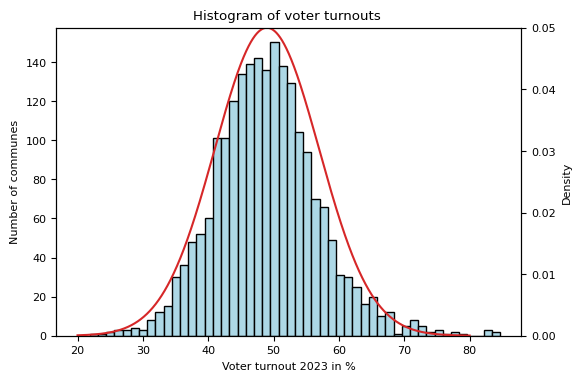

In [33]:
fig, ax1 = plt.subplots(1, 1,figsize=(6, 4))
plt.title("Histogram of voter turnouts ")
ax1.set_ylabel("Number of communes")
ax1.set_xlabel("Voter turnout 2023 in %")
ax1.hist(data['turnout2023'], bins=50, ec="black", color="lightblue")
ax2 = ax1.twinx()
ax2.set_ylim(bottom=0, top=0.05)
ax2.set_ylabel("Density")
ax2.plot(
    np.arange(20, 80, 0.01), 
    norm.pdf(np.arange(20, 80, 0.01), data['turnout2023'].mean(), data['turnout2023'].std()), 
    color='tab:red'
)

In [ ]:
fig, axs = plt.subplots(11, 3, figsize=(20, 60))
i = 0
for column in data.columns:
  if column != "Municipality" and column != "turnout2023" and column != "turnout2019" and column != "turnout_NE_2021":
    sns.histplot(data=data, bins=25, x=column, kde=True, color="skyblue", ax=axs[ i % 11, i % 3])
    i = i+1

## Calculate correlations and plot them
Calculate Pearsons correlation coeffiecient for each variable and the voter turnout from 2023.
As a comparison value we use the the voter turnout from 2019.

In [ ]:
correlations = pd.DataFrame()
m = 0
for column in data_std.columns:
  if column != 'Municipality' and column != 'turnout2023' and column != "turnout2019":
    mask = data_std[column].isna()
    df = data_std[~mask] 
    df = df[[column, "turnout2023", "turnout2019"]]
    if len(df.index) > 0:
      new_row = pd.DataFrame({ 
        'correlation 2019' : df['turnout2019'].corr(df[column]),
        'correlation 2023' : df['turnout2023'].corr(df[column])
    }, index=[column])
    correlations = pd.concat([new_row, correlations.loc[:]]) #.reset_index(drop=True)

In [ ]:
correlations = correlations.sort_values("correlation 2023", ascending=False)
correlations
plt.rcParams.update({'font.size': 8})
ax = correlations.plot.barh(figsize=(4,8))

## Scatter plot and linear regression  line

In [ ]:
columnsX = ['Percentage of foreign nationals', 'Social assistance rate', 'Residents 65+ years (%)'] # 
columnY = "turnout2023" #turnout
fig, axs = plt.subplots(3, 2, figsize=(12, 14))

# Add more vertical space between the subplots
plt.subplots_adjust(hspace=0.4)

i = 0
for column in columnsX:

  # remove NaN values
  df = data[~data[column].isna()] 
  #df = df[~data[columnY].isna()] 

  # linear regression with scipy
  x = df[column].astype(float)
  y = df[columnY].astype(float)
  slope, intercept, r, p, se = linregress(x, y)
    
  # Create the scatter plot with regression line on the ax in the first column
  axs[i, 0].set_title("Scatter plot with regression line")
  axs[i, 0].scatter(df[column], df[columnY], s = 1)
  axs[i, 0].plot(x, x*slope + intercept, color="orange")
  axs[i, 0].set_xlabel(column + '\n\n(R²-score: ' + str(round(r2_score(y, x*slope + intercept), 2)) + ')')
  axs[i, 0].set_ylabel(columnY)

  # Create the residual plot (with seaborn) on the ax in the second column (see paramter ax in residplot)
  axs[i, 1].set_title("Residual plot")
  sns.residplot(x=column, y=columnY, data=df, scatter_kws=dict(s=1), ax=axs[i, 1])
  axs[i, 1].set_ylabel("Residuals")

  i = i + 1

In [ ]:
columnX = "Percentage of foreign nationals"
columnY = "turnout_NE_2021" #turnout
fig, axs = plt.subplots(1, 1, figsize=(5, 3))

i = 0

# remove NaN values
df = data[~data[columnY].isna()] 

# linear regression with scipy
x = df[columnX].astype(float)
y = df[columnY].astype(float)
slope, intercept, r, p, se = linregress(x, y)
    
# Create the scatter plot with regression line on the ax in the first column
axs.set_title("Scatter plot with regression line")
axs.scatter(df[columnX], df[columnY], s = 1)
axs.plot(x, x*slope + intercept, color="orange")
axs.set_xlabel(columnX + '\n\n(R²-score: ' + str(round(r2_score(y, x*slope + intercept), 2)) + ')')
axs.set_ylabel(columnY)

In [ ]:
# https://docs.bokeh.org/en/latest/docs/examples/basic/scatters/elements.html
# import pandas as pd

columnX = "Percentage of foreign nationals"
columnY = "turnout2023" #turnout
df = data[~data[columnX].isna()] 
    
#elements = elements.copy()
#elements = elements[elements["atomic number"] <= 82]
#elements = elements[~pd.isnull(elements["melting point"])]
#mass = [float(x.strip("[]")) for x in elements["atomic mass"]]
#elements["atomic mass"] = mass

palette = ["#053061", "#2166ac", "#4393c3", "#92c5de", "#d1e5f0",
           "#f7f7f7", "#fddbc7", "#f4a582", "#d6604d", "#b2182b", "#67001f"]

#melting_points = elements["melting point"]
#low = min(melting_points)
#high = max(melting_points)
#melting_point_inds = [int(10*(x-low)/(high-low)) for x in melting_points] #gives items in colors a value from 0-10
#elements['melting_colors'] = [palette[i] for i in melting_point_inds]

TITLE = "Interactice scatter plot"
TOOLS = "hover,pan,wheel_zoom,reset,save"

p = figure(tools=TOOLS, toolbar_location="above", sizing_mode='stretch_both', title=TITLE, margin=(25,50,25,25))
p.toolbar.logo = "grey"
p.background_fill_color = "#efefef"
p.xaxis.axis_label = columnX
p.yaxis.axis_label = "Voter turnout federal elections 2023"
p.grid.grid_line_color = "white"
p.hover.tooltips = [
    ("Swiss commune", "@Municipality"),
    ("Residents:", "@Residents"),
    ("Voter turnout federal elections 2023", "@{turnout2023}%"),
    (columnX, "@{Percentage of foreign nationals}%")
]

source = ColumnDataSource(df)

p.scatter(columnX, columnY, size=6, source=source, #color='melting_colors',
           line_color="black", alpha=0.9)

# linear regression with scipy
x = df[columnX].astype(float)
y = df[columnY].astype(float)
slope, intercept, r2, p_1, se = linregress(x, y)

orange = Inferno11[8]

slope = Slope(gradient=slope, y_intercept=intercept,
              line_color=orange, line_width=2)

p.add_layout(slope)

show(p)